In [39]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

SHEET_ID = "1rD8NC-QPCi30sTVFksbxc4Rhj2L9gfQ84gyJ0lO5xoA"

# https://docs.google.com/spreadsheets/d/1rD8NC-QPCi30sTVFksbxc4Rhj2L9gfQ84gyJ0lO5xoA/edit?usp=sharing

GID = "0"  # aba Página1
url_tsv = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=tsv&gid={GID}"

# TSV + vírgula decimal
# df = pd.read_csv(url_tsv, sep="\t", decimal=",")

df = pd.read_csv('data.csv')

df = df.drop(columns=['Unnamed: 32'], errors='ignore')

print("Colunas lidas:", list(df.columns))
display(df.head())

Colunas lidas: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [40]:
#FEATURES = ["latitude", "longitude", "altitude_m"]
FEATURE_SETS = {
    "APENAS_TAMANHO": ["radius_mean", "area_mean", "perimeter_mean"],
    "APENAS_TEXTURA": ["texture_mean", "smoothness_mean", "compactness_mean"],
    "MISTURA_TOP": ["radius_mean", "texture_mean", "concavity_mean", "symmetry_mean"]
}

FEATURES = FEATURE_SETS["APENAS_TAMANHO"]

TARGET = "diagnosis"            # coluna F (classe)

for col in FEATURES:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Normaliza o target e remove linhas inválidas
df[TARGET] = df[TARGET].astype(str).str.strip().str.lower()
df = df.dropna(subset=FEATURES + [TARGET]).copy() #remove linhas com valores inválidos

print("\nDistribuição do target:")
print(df[TARGET].value_counts())



Distribuição do target:
diagnosis
b    357
m    212
Name: count, dtype: int64


In [41]:
le = LabelEncoder()
y_all = le.fit_transform(df[TARGET])
X_all = df[FEATURES].values

print("\nClasses:", list(le.classes_))
print("Total linhas válidas:", len(df))


Classes: ['b', 'm']
Total linhas válidas: 569


In [42]:

RANDOM_STATE = 42
df_shuffled = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
limite_teste=int(len(df)*0.20) # Split : 20% teste + 80% treino
test_df  = df_shuffled.iloc[:limite_teste].copy()
train_df = df_shuffled.iloc[limite_teste:len(df)].copy()
X_train = train_df[FEATURES].values
y_train = le.transform(train_df[TARGET])
X_test  = test_df[FEATURES].values
y_test  = le.transform(test_df[TARGET])
print("\nTreino:", len(train_df), "| Teste:", len(test_df))



Treino: 456 | Teste: 113


In [43]:
def dist_classes(frame, target_col, titulo):
    vc = frame[target_col].value_counts(dropna=False)
    pct = (vc / len(frame) * 100).round(1)
    out = pd.DataFrame({"qtd": vc, "%": pct})
    print(f"\n=== {titulo} (n={len(frame)}) ===")
    display(out)

dist_classes(df, TARGET, "Dataset completo")
dist_classes(train_df, TARGET, "Treino")
dist_classes(test_df, TARGET, "Teste")


=== Dataset completo (n=569) ===


,qtd,%
diagnosis,,
b,357,62.7
m,212,37.3



=== Treino (n=456) ===


,qtd,%
diagnosis,,
b,286,62.7
m,170,37.3



=== Teste (n=113) ===


,qtd,%
diagnosis,,
b,71,62.8
m,42,37.2


In [44]:
# Modelo KNN
K = 5
WEIGHTS = "distance"  # "uniform" ou "distance"

model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=K, weights=WEIGHTS))
])

model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(weights='distance'))])

In [45]:
# Avaliação

y_pred = model.predict(X_test)

print("\nFeatures usadas:", FEATURES)
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Matriz de confusão (real x previsto):")
print(confusion_matrix(y_test, y_pred))



Features usadas: ['radius_mean', 'area_mean', 'perimeter_mean']
Acurácia: 0.9557522123893806

Relatório:
              precision    recall  f1-score   support

           b       0.96      0.97      0.97        71
           m       0.95      0.93      0.94        42

    accuracy                           0.96       113
   macro avg       0.95      0.95      0.95       113
weighted avg       0.96      0.96      0.96       113

Matriz de confusão (real x previsto):
[[69  2]
 [ 3 39]]


In [46]:
# Resultado detalhado do teste
test_df["classe_prevista"] = le.inverse_transform(y_pred)
display(test_df[["id"] + FEATURES + [TARGET, "classe_prevista"]])

,id,radius_mean,area_mean,perimeter_mean,diagnosis,classe_prevista
0,87930,12.47,481.9,81.09,b,b
1,859575,18.94,1130.0,123.60,m,m
2,8670,15.46,748.9,101.70,m,m
3,907915,12.40,467.8,81.47,b,b
4,921385,11.54,402.9,74.65,b,b
...,...,...,...,...,...,...
108,86973702,14.44,640.1,93.97,b,b
109,913102,14.64,666.0,94.21,b,b
110,8610404,16.07,817.7,104.10,m,m
111,884689,11.52,406.3,73.87,b,b



=== Árvore de decisão ===
Features usadas: ['radius_mean', 'area_mean', 'perimeter_mean']
Acurácia: 0.8849557522123894

Relatório:
              precision    recall  f1-score   support

           b       0.87      0.96      0.91        71
           m       0.91      0.76      0.83        42

    accuracy                           0.88       113
   macro avg       0.89      0.86      0.87       113
weighted avg       0.89      0.88      0.88       113

Matriz de confusão (real x previsto):
[[68  3]
 [10 32]]


,id,radius_mean,area_mean,perimeter_mean,diagnosis,classe_prevista_arvore
0,87930,12.47,481.9,81.09,b,b
1,859575,18.94,1130.0,123.60,m,m
2,8670,15.46,748.9,101.70,m,m
3,907915,12.40,467.8,81.47,b,b
4,921385,11.54,402.9,74.65,b,b
...,...,...,...,...,...,...
108,86973702,14.44,640.1,93.97,b,b
109,913102,14.64,666.0,94.21,b,b
110,8610404,16.07,817.7,104.10,m,m
111,884689,11.52,406.3,73.87,b,b


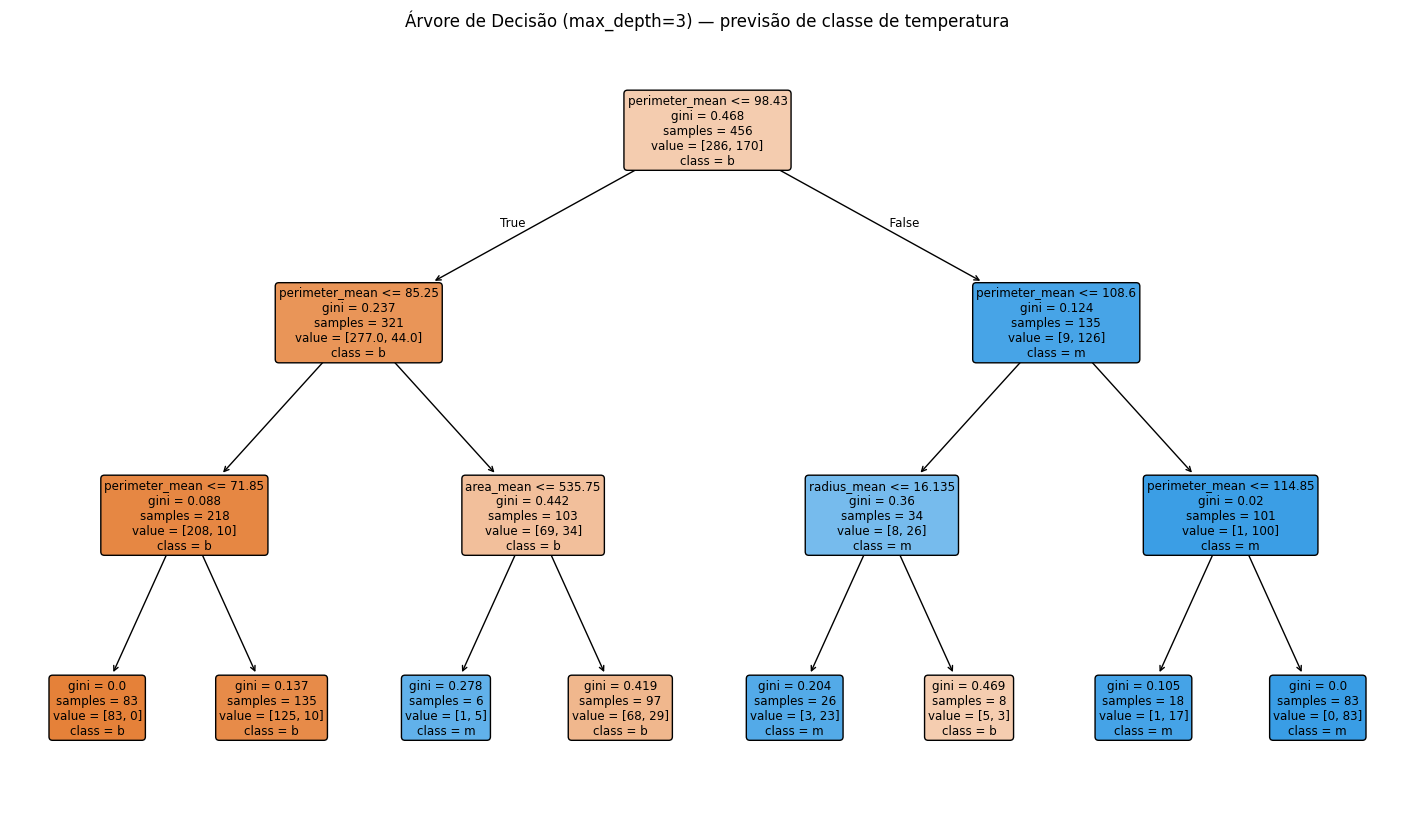

In [47]:
# ========= Árvore de decisão (usando as MESMAS variáveis do seu Colab) =========
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# "simples" e legível para aula (ajuste se quiser):
tree = DecisionTreeClassifier(
    max_depth=3,          # controla complexidade/legibilidade
    random_state=RANDOM_STATE
)

tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("\n=== Árvore de decisão ===")
print("Features usadas:", FEATURES)
print("Acurácia:", accuracy_score(y_test, y_pred_tree))
print("\nRelatório:")
print(classification_report(y_test, y_pred_tree, target_names=le.classes_))
print("Matriz de confusão (real x previsto):")
print(confusion_matrix(y_test, y_pred_tree))

# Resultado detalhado do teste (sem mudar sua tabela do KNN, usa outra coluna)
test_df["classe_prevista_arvore"] = le.inverse_transform(y_pred_tree)
display(test_df[["id"] + FEATURES + [ TARGET, "classe_prevista_arvore"]])

# desenhar a árvore
plt.figure(figsize=(18, 10))
plot_tree(
    tree,
    feature_names=FEATURES,
    class_names=list(le.classes_),
    filled=True,
    rounded=True,
    impurity=True
)
plt.title("Árvore de Decisão (max_depth=3) — previsão de classe de temperatura")
plt.show()